
 
 ## Language modeling - Generate movie reviews
<br>
<font color= 'green' > 
- NIMISHA ASATI


</H> **Importing the necessary Libraries** </H>

In [8]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
from torchtext import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using TensorFlow backend.


In [9]:
%matplotlib inline

## 1.A Build a Markov (n-gram) language model

We have a markov model trigram model. Torch test was used to retrieve the IMDB dataset and custom function generate trigrams is passed to the preprocessing argument in the data.field function to function each review into trigrams and freqs function is used to get the count of each trigram. This data is further manipulated to calculate probabilties and predictions are made my smapling these probabilities

In [17]:
def generate_trigrams(x):
    res = []
    n_grams = list(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        res.append(' '.join(n_gram))
    return res

In [18]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
##############importing imdb daasets#############
TEXT = data.Field(tokenize='spacy',preprocessing=generate_trigrams)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.9)
TEXT.build_vocab(train_data)
dictionary = dict(TEXT.vocab.freqs)

{'text': ['a bit slow', 'bit slow and', 'slow and boring', 'and boring ,', 'boring , the', ', the tale', 'the tale of', 'tale of an', 'of an old', 'an old man', 'old man and', 'man and his', 'and his wife', 'his wife living', 'wife living a', 'living a delapidated', 'a delapidated building', 'delapidated building and', 'building and interacting', 'and interacting with', 'interacting with a', 'with a fixed', 'a fixed cast', 'fixed cast of', 'cast of characters', 'of characters like', 'characters like the', 'like the mailman', 'the mailman ,', 'mailman , the', ', the brothers', 'the brothers sitting', 'brothers sitting on', 'sitting on the', 'on the porch', 'the porch ,', 'porch , the', ', the wealthy', 'the wealthy cigar', 'wealthy cigar smoking', 'cigar smoking man', 'smoking man .', 'man . The', '. The photography', 'The photography of', 'photography of the', 'of the river', 'the river is', 'river is marvelous', 'is marvelous ,', 'marvelous , as', ', as is', 'as is the', 'is the inter

In [21]:
markov = pd.DataFrame.from_dict(dictionary,orient="index")
markov = markov.reset_index()
markov.columns = ['trigrams','cnt']
markov['bigram'] =markov.trigrams.apply(lambda x: " ".join(x.split(' ')[:2]))
markov['target'] =markov.trigrams.apply(lambda x: x.split(' ')[2])
inp_cnt = pd.DataFrame(markov.groupby("bigram",as_index=False)["cnt"].sum())

## 1.B Change the output appropriately in ‘Simple Sentiment Analysis.ipynb’ to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.


In [2]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [3]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [4]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [5]:
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.25)

{'text': ['a', 'bit', 'slow', 'and', 'boring', ',', 'the', 'tale', 'of', 'an', 'old', 'man', 'and', 'his', 'wife', 'living', 'a', 'delapidated', 'building', 'and', 'interacting', 'with', 'a', 'fixed', 'cast', 'of', 'characters', 'like', 'the', 'mailman', ',', 'the', 'brothers', 'sitting', 'on', 'the', 'porch', ',', 'the', 'wealthy', 'cigar', 'smoking', 'man', '.', 'The', 'photography', 'of', 'the', 'river', 'is', 'marvelous', ',', 'as', 'is', 'the', 'interior', 'period', 'decoration', '.', 'If', 'you', 'like', 'decoration', 'of', 'Banana', 'Republic', 'stores', ',', 'this', 'is', 'a', 'must', '.'], 'label': 'pos'}


In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2500
Number of validation examples: 22500
Number of testing examples: 25000


In [7]:
TEXT.build_vocab(train_data, max_size=1000)
LABEL.build_vocab(train_data)

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 5002
Unique tokens in LABEL vocabulary: 2


In [9]:
BATCH_SIZE = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

In [10]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim,BATCH_SIZE,output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, output_dim)
        
    def forward(self, x):        
        embedded = self.embedding(x)
        output, (hidden,cell) = self.rnn(embedded)
        dim = output.size()
        output = output.view(-1, output.shape[2])
        output1 = F.log_softmax(output,dim=1)
        
        if BATCH_SIZE==dim[1]:
            output1 = output1.view(-1,OUTPUT_DIM,BATCH_SIZE)
        else:
            output1 = output1.view(dim[1],OUTPUT_DIM,-1)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]       
        return output1

In [11]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = len(TEXT.vocab)
model = RNN(INPUT_DIM, EMBEDDING_DIM,BATCH_SIZE,OUTPUT_DIM)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [13]:
def train(model, iterator, optimizer, criterion,BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()   
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [20]:
N_EPOCHS = 10
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss,train_acc = train(model, train_iterator, optimizer, criterion,BATCH_SIZE)
    train_losses.append(train_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% ')#| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 6.036 | Train Acc: 9.35% 
| Epoch: 02 | Train Loss: 5.691 | Train Acc: 9.07% 
| Epoch: 03 | Train Loss: 5.683 | Train Acc: 8.88% 
| Epoch: 04 | Train Loss: 5.681 | Train Acc: 9.59% 
| Epoch: 05 | Train Loss: 5.680 | Train Acc: 9.06% 
| Epoch: 06 | Train Loss: 5.674 | Train Acc: 9.06% 
| Epoch: 07 | Train Loss: 5.675 | Train Acc: 8.58% 
| Epoch: 08 | Train Loss: 5.671 | Train Acc: 9.33% 
| Epoch: 09 | Train Loss: 5.679 | Train Acc: 9.20% 
| Epoch: 10 | Train Loss: 5.670 | Train Acc: 9.22% 


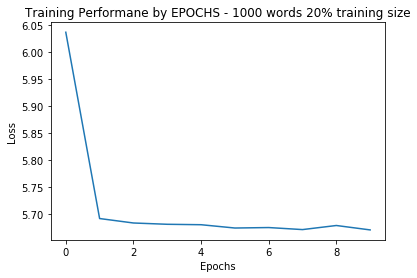

In [22]:
plt.plot(train_losses)
plt.title("Training Performane by EPOCHS - 1000 words 25% training size")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## 2. For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.


**Markov** model we went with the trigrams and there was no difficulty in calculating the probabilities and prediction.

For **LSTM** there was an input layer followed by embedding then lstm layer. The input was the tokenized text and output also the tokenized text offsetted by 1 place. Ex) if input is [This,is,my,favorite,movie] then output is [is,my,favorite,movie,<<pad>>]. If you give the word "This" then model should predict "is" and so on. Due to the size of the input training model with a decent training size became a struggle.
    
- We took 25% training data with max 1000 words with batch size 10 to train our lstm model.
- If we increased the number of words then the model couldn't be loaded into the gpu as there was insufficient memory
- If we increased the training data to higher percentage say 50% or 80% then notebook got disconnected from the server randomly. This error didn't go when we tried to run the code as standalone .py file instead of a python notebook
- When we reduced the batch size to 1 then model took longer time to train and when we increased it to 64 then there was memory error once again. We settled at Batch Size 10
- Due to this limited training size and words the quality of sentence formed by predicition was affected considerably.The prediction didn't give out a coherent sentence as we would have liked.

## 3. For each model, starting with the phrase ”My favorite movie ”, sample the next few words and create a 20 word generated review. 

## Markov Prediction 

In [24]:
def generate_sentence(sentence,no_preds,prediction_length):
    prediction_length -= len(sentence.split(" ")) 
    for j in range(0,no_preds):
        pred_sentence = sentence
        bi = " ".join(pred_sentence.split(" ")[1:])
        for i in range(0,prediction_length):
            poss_pred = np.array(markov.target[markov.bigram==bi])
            scores = np.array(markov.cnt[markov.bigram==bi])
            length = inp_cnt.cnt[inp_cnt.bigram==bi]
            probs = scores/length.iloc[0]
            pred = random.choice(list(enumerate(probs)))[0]
            pred = poss_pred[pred]
            pred_sentence = pred_sentence + " " + pred
            bi = " ".join([bi.split(" ")[1],pred])
        print("Generated Review "+str(j+1)+": ",pred_sentence+"\n")
generate_sentence("my favorite movie",5,20)

Generated Review 1:  my favorite movie - lovers become involved . The sight of Joe McCarthy ) , Pastor Dan , Hedges also

Generated Review 2:  my favorite movie growing up experience I 've showed this at tower records after seeing Mario Van Peeples surprised me

Generated Review 3:  my favorite movie rental store just to earn them any awards that 's above and , here giving one of

Generated Review 4:  my favorite movie genre of your brother - type role as Robinson 's boss , Tony Franciosa and things .

Generated Review 5:  my favorite movie ahead of Raines and it betrayed me . Another annoying character to fill a whole Kill Shot



# LSTM Prediction

In [16]:
for j in range(5):
    inp =torch.tensor([[TEXT.vocab.stoi["my"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
    for i in range(17):
        op = model(inp)
        op = op.squeeze(0)
        op = op[:,op.size()[1]-1].detach().cpu().numpy()
        op = np.sort(op)[::-1]
        op = op[:500] 
        new_inp = torch.tensor(np.where(op==np.random.choice(op,1)),device="cuda:0")
        inp = torch.cat((inp,new_inp))
    
    generated_text = ""
    for val in inp:
        generated_text = generated_text + " " + TEXT.vocab.itos[val]
    print("Generated Review "+str(j+1)+": ",generated_text+"\n")

Generated Review 1:   my favorite movie women my around top should black find rest children Well few still top start were performances become

Generated Review 2:   my favorite movie waste funny your end moments awful death an seeing guy completely real Not around When children guy

Generated Review 3:   my favorite movie who enough wife came get 's performances want were No enough play should more rather come American

Generated Review 4:   my favorite movie even believe house definitely what scenes worth camera friends version love In me work absolutely after need

Generated Review 5:   my favorite movie tries sort remember if their episode at minutes wife around thought mother day up style Do films

